In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io
from PIL import Image
import cv2

import random

In [2]:
import os
from google.colab import userdata

try:
    os.environ['KAGGLE_USERNAME'] = "lufthansa454"
    os.environ['KAGGLE_KEY'] = "KGAT_2c8ff1dfe135f6b618f19f04faedfe72"           # 예: "2893..." (긴 숫자+문자 조합)
    print("User Info being set")
except:
    print("User info has not been set")


!kaggle datasets download -d balraj98/berkeley-segmentation-dataset-500-bsds500

!unzip -q berkeley-segmentation-dataset-500-bsds500.zip -d ./bsds500

print("Dataset Downlaod and Unzip Complete")

User Info being set
Dataset URL: https://www.kaggle.com/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500
License(s): other
berkeley-segmentation-dataset-500-bsds500.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./bsds500/ground_truth/test/100007.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Dataset Downlaod and Unzip Complete


In [3]:
head_path = "/content/bsds500"
ground_truth_path = os.path.join(head_path, "ground_truth")
# 해당 폴더 내의 파일들은 Segmentation 혹은 Edge Detection, Rand Error / Warping Error 평가 시에 사용되는 데이터로,
# 본 파일에서 진행 할 Denoising에서는 사용하지 않는다.

images_path = os.path.join(head_path, "images")
files = os.listdir(head_path)
print(files)
print(os.listdir(ground_truth_path))
print(os.listdir(images_path))

num_test_img = len(os.listdir(os.path.join(images_path, "test")))
num_train_img = len(os.listdir(os.path.join(images_path, "train")))
num_val_img = len(os.listdir(os.path.join(images_path, "val")))

print(f"\nTest 이미지 개수 : {num_test_img}")
print(f"Train 이미지 개수 : {num_train_img}")
print(f"Valid 이미지 개수 : {num_val_img}")

['ground_truth', 'images']
['val', 'train', 'test']
['val', 'train', 'test']

Test 이미지 개수 : 201
Train 이미지 개수 : 201
Valid 이미지 개수 : 101


In [4]:
train_path = os.path.join(images_path, "train")
test_path = os.path.join(images_path, "test")
val_path = os.path.join(images_path, "val")

Image format : JPEG
Image size : (481, 321)
Image channel : RGB


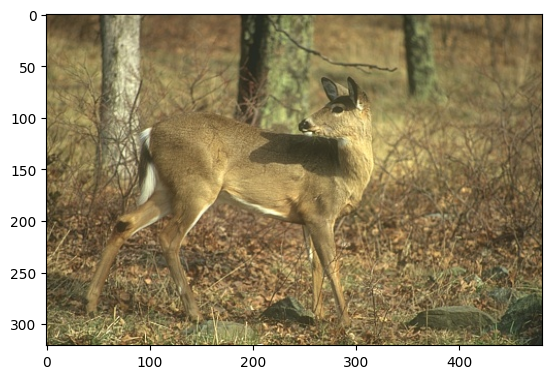

In [5]:
image_files = os.listdir(train_path)

image_files = [f for f in image_files if f.lower().endswith('.jpg')] # 'Thunbs.db' 파일도 섞여있기 떄문에 사진 파일만 필터링


first_image_filename = image_files[0]
first_image_path = os.path.join(train_path, first_image_filename)
img = Image.open(first_image_path)
plt.imshow(img)
print(f"Image format : {img.format}")
print(f"Image size : {img.size}")
print(f"Image channel : {img.mode}")
plt.show()

In [6]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomCrop(40),

    transforms.RandomChoice([
        transforms.RandomRotation((0, 0)),
        transforms.RandomRotation((90, 90)),
        transforms.RandomRotation((180, 180)),
        transforms.RandomRotation((270, 270))
    ]),

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, images_path, mode, noise_factor, transform=None):
        self.transform = transform
        self.images_path = images_path
        self.mode = mode
        self.noise_factor = noise_factor

        self.img_files = sorted(os.listdir(self.images_path))
        self.img_files = [f for f in self.img_files if f.lower().endswith('.jpg')]

    def __len__(self):
        #return len(os.listdir(self.img_files))
        return len(self.img_files)

    def __getitem__(self, idx):
        clean_image = Image.open(os.path.join(self.images_path, self.img_files[idx])).convert("RGB")
        #clean_image = Image.open(self.img_files[idx]).convert("L")
        clean_image = Image.open(os.path.join(self.images_path, self.img_files[idx])).convert("L")
        if self.transform:
            clean_image = self.transform(clean_image)

            # 여기서 noise 적용하기

            sigma = self.noise_factor / 255.0
            noise = torch.randn_like(clean_image) * sigma
            noisy_image = clean_image + noise
            noisy_image = torch.clamp(noisy_image, 0.0, 1.0)

        return noisy_image, clean_image

In [8]:
train_dataset = CustomDataset(train_path, mode='train', noise_factor=15, transform=train_transform)
test_dataset = CustomDataset(test_path, mode='test', noise_factor=15, transform=val_transform)
val_dataset = CustomDataset(val_path, mode='val', noise_factor=15, transform=val_transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

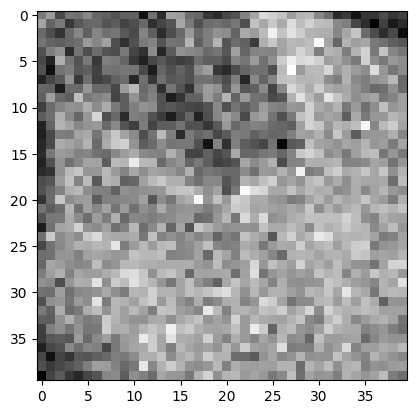

In [10]:
dataiter = iter(train_loader)
noisy_images, clean_images = next(dataiter)

noisy_images.shape

img_show = noisy_images[0].squeeze(0)
plt.imshow(img_show, cmap='gray')
plt.show()

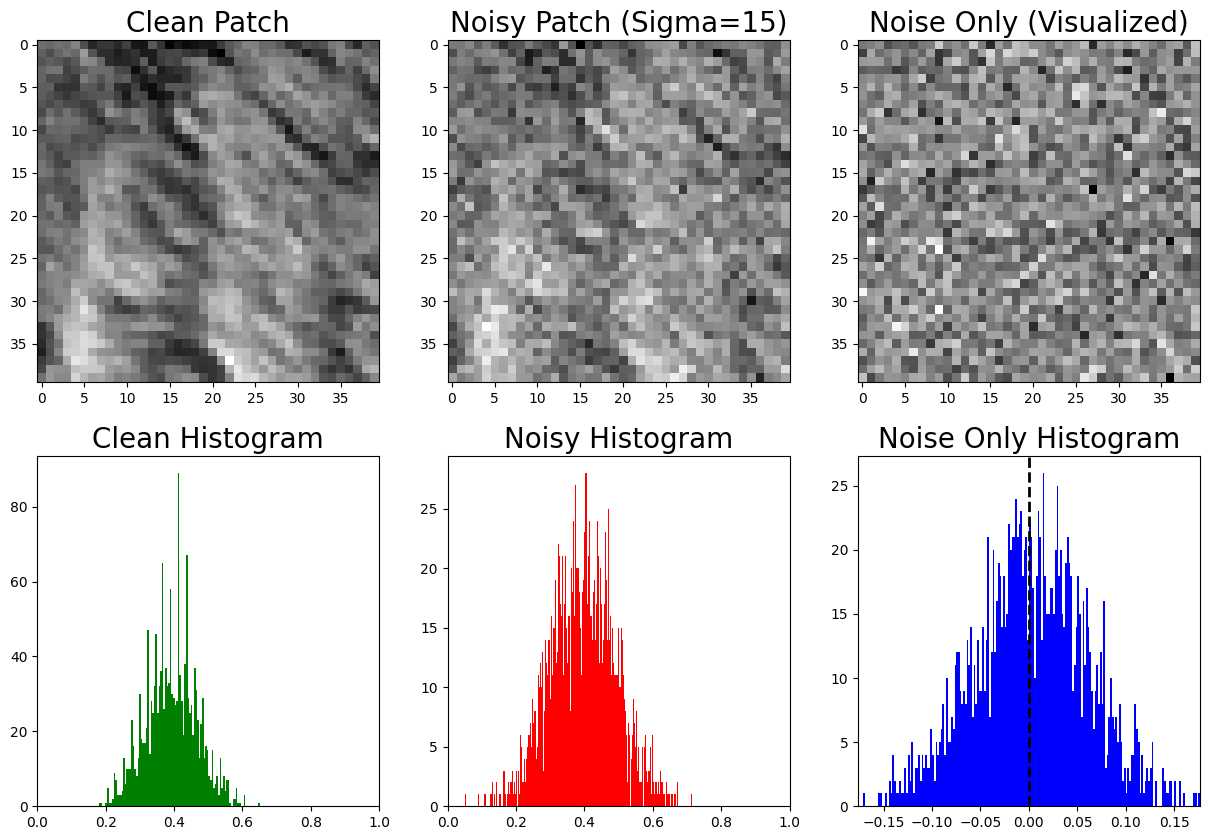

In [11]:
def analyze(dataset, idx=0):
    noisy_tensor, clean_tensor = dataset[idx]

    noise_only_tensor = noisy_tensor - clean_tensor

    clean_flat = clean_tensor.flatten().numpy()
    noisy_flat = noisy_tensor.flatten().numpy()
    noise_flat = noise_only_tensor.flatten().numpy()

    # 행 열 순서

    plt.figure(figsize=(15, 10))

    plt.subplot(231)
    plt.imshow(clean_tensor.squeeze().numpy(), cmap='gray')
    plt.title("Clean Patch", fontsize=20)

    plt.subplot(232)
    plt.imshow(noisy_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Noisy Patch (Sigma={dataset.noise_factor})", fontsize=20)

    plt.subplot(233)
    vis_noise = noise_only_tensor.squeeze().numpy()
    vis_noise = (vis_noise - vis_noise.mean()) / (vis_noise.max() - vis_noise.min())
    plt.imshow(vis_noise, cmap='gray')
    plt.title("Noise Only (Visualized)", fontsize=20)

    plt.subplot(234)
    plt.hist(clean_flat, bins=100, color='green')
    plt.title("Clean Histogram", fontsize=20)
    plt.xlim(0, 1)

    plt.subplot(235)
    plt.hist(noisy_flat, bins=220, color='red')
    plt.title("Noisy Histogram", fontsize=20)
    plt.xlim(0,1)

    plt.subplot(236)
    plt.hist(noise_flat, bins=220, color='blue')
    plt.title("Noise Only Histogram", fontsize=20)
    sigma_scale = dataset.noise_factor / 255.0
    plt.xlim(-3*sigma_scale, 3*sigma_scale)
    plt.axvline(0, color='k', linestyle='dashed', linewidth=2)


    plt.show()

analyze(train_dataset, 0)

In [12]:
class DnCNN(nn.Module):
    def __init__(self, n_channels=1, n_layers=17):
        super().__init__()

        # Stem
        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Body (수정 필요)
        layers=[]
        for _ in range(n_layers - 2):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
        self.body = nn.Sequential(*layers) # Unpack해서 각각으로 만들어주기

        # Head
        self.last_layer = nn.Sequential(
            nn.Conv2d(64, n_channels, 3, padding=1)
        )

    def forward(self, x):
        out = self.layer1(x)

        #x = self.body() # layer2 ~ layer 16
        out = self.body(out)

        out = self.last_layer(out)

        return out # (입력 - 예측노이즈)

In [13]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Kaiming Normal (He 초기화) - ReLU를 쓰는 모델에 적합
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        # BatchNorm은 weight 1, bias 0으로 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DnCNN().to(device)
model.apply(weights_init_kaiming)

DnCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (body): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 64

In [15]:
n_epochs = 200

criterion = nn.MSELoss(reduction='mean')
optimizer_Adam = optim.Adam(model.parameters(), lr = 0.0001)
optimizer_SGD = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# 0.1에서 시작, 50 epoch동안 0.0001로 감소
#scheduler_ex = optim.lr_scheduler.ExponentialLR(optimizer_Adam, gamma=0.871)
#scheduler_ms = optim.lr_scheduler.MultiStepLR(optimizer_Adam, milestones=[30, 40], gamma=0.1)
scheduler_step = optim.lr_scheduler.StepLR(optimizer_Adam, step_size=10, gamma=0.1)
#scheduler_lambda = optim.lr_scheduler.LambdaLR(optimizer_Adam, lr_lambda=lambda epoch: 0.871 ** epoch)


modle_test = nn.Linear(10, 5)
#Exponential Scheduler, Lambda Scheduler 사용해서 비교해보기

In [16]:
INF = 1000
def calculate_PSNR(image1, image2):
    mse = torch.mean((image1 - image2) ** 2)
    if mse == 0:
        return INF
    return 10 * torch.log10(1.0 / mse) # R은 픽셀의 최대값으로, 8비트 unsigned int : 255, double/float : 1

In [17]:
def train_Adam(model, train_loader, optimizer_Adam, criterion, epoch):
    model.train()

    running_loss = 0.0
    running_psnr = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # inputs : Noisy, targets : Clean Image
        # loss 구할 때 targets가 깨끗한 이미지로 들어가면 안됨.
        # Loss = MSE(output, clean_img) : X
        # Loss = MSE(output, (noisy - clean)) : O

        optimizer_Adam.zero_grad()
        outputs = model(inputs)

        #loss = criterion(outputs, targets)
        real_noise = inputs - targets # (Noisy - Clean)
        loss = criterion(outputs, real_noise)

        denoised_img = inputs - outputs # (Noisy - Denoised)
        #denoised_img = torch.clamp(denoised_img, 0.0, 1.0) # 중요!!!

        # Train에서는 clamp를 적용하지 말아야 한다??

        loss.backward()
        optimizer_Adam.step()

        running_loss += loss.item()
        running_psnr += calculate_PSNR(denoised_img, targets).item()

    epoch_loss = running_loss / len(train_loader)
    epoch_psnr = running_psnr / len(train_loader)

    print(f"\nEpoch {epoch} Train - Loss : {epoch_loss:.6f}, PSNR : {epoch_psnr:.2f} dB")
    return epoch_loss, epoch_psnr

In [18]:
def val_Adam(model, val_loader, optimizer_Adam, criterion, epoch):
    model.eval()

    val_loss = 0.0
    val_psnr = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            #loss = criterion(outputs, targets)
            real_noise = inputs - targets
            loss = criterion(outputs, real_noise)

            denoised_img = inputs - outputs
            #denoised_img = torch.clamp(denoised_img, 0.0, 1.0) # GPT :

            val_loss += loss.item()
            val_psnr += calculate_PSNR(denoised_img, targets).item()
    val_avg_loss = val_loss / len(val_loader)
    val_avg_psnr = val_psnr / len(val_loader)

    print(f"Epoch {epoch} Valid - Loss : {val_avg_loss:.6f}, PSNR : {val_avg_psnr:.2f} dB\n\n\n")
    #print(f"Validation inputs : {inputs.max()}")
    return val_avg_loss, val_avg_psnr

In [19]:
def test_Adam(model, test_loader, optimizer_Adam, criterion, epoch):
    model.eval()

    test_loss = 0.0
    test_psnr = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            real_noise = inputs - targets
            loss = criterion(outputs, real_noise)

            denoised_img = inputs - outputs
            #denoised_img = torch.clamp(denoised_img, 0.0, 1.0)

            test_loss += loss.item()
            test_psnr += calculate_PSNR(denoised_img, targets).item()
    avg_loss = test_loss / len(test_loader)
    avg_psnr = test_psnr / len(test_loader)

    print(f"Epoch {epoch} Test - Loss : {avg_loss:.6f}, PSNR : {avg_psnr:.2f} dB")
    return avg_loss, avg_psnr

In [20]:
best_psnr = 0.0
best_model_wts = None

train_loss = []
train_psnr = []
val_psnr_hist = []

for epoch in range(n_epochs):
    loss, psnr = train_Adam(model, train_loader, optimizer_Adam, criterion, epoch+1)
    train_loss.append(loss)
    train_psnr.append(psnr)

    val_loss_epoch, val_psnr_epoch = val_Adam(model, val_loader, optimizer_Adam, criterion, epoch+1)
    val_psnr_hist.append(val_psnr_epoch)

    if val_psnr_epoch > best_psnr:
        best_psnr = val_psnr_epoch
        best_model_wts = model.state_dict()

    #scheduler_ms.step()
    #scheduler_step.step()
    #scheduler_lambda.step()
    current_lr = optimizer_Adam.param_groups[0]['lr']
    print(f"Current Learning Rate : {current_lr}")

model.load_state_dict(best_model_wts)


Epoch 1 Train - Loss : 0.526181, PSNR : 2.81 dB
Epoch 1 Valid - Loss : 0.035485, PSNR : 14.63 dB



Current Learning Rate : 0.0001

Epoch 2 Train - Loss : 0.395271, PSNR : 4.04 dB
Epoch 2 Valid - Loss : 0.105320, PSNR : 10.41 dB



Current Learning Rate : 0.0001

Epoch 3 Train - Loss : 0.269459, PSNR : 5.72 dB
Epoch 3 Valid - Loss : 0.163400, PSNR : 8.86 dB



Current Learning Rate : 0.0001

Epoch 4 Train - Loss : 0.188367, PSNR : 7.27 dB
Epoch 4 Valid - Loss : 0.216320, PSNR : 8.18 dB



Current Learning Rate : 0.0001

Epoch 5 Train - Loss : 0.123279, PSNR : 9.14 dB
Epoch 5 Valid - Loss : 0.186544, PSNR : 8.83 dB



Current Learning Rate : 0.0001

Epoch 6 Train - Loss : 0.081312, PSNR : 10.94 dB
Epoch 6 Valid - Loss : 0.130198, PSNR : 10.21 dB



Current Learning Rate : 0.0001

Epoch 7 Train - Loss : 0.059568, PSNR : 12.31 dB
Epoch 7 Valid - Loss : 0.099753, PSNR : 11.47 dB



Current Learning Rate : 0.0001

Epoch 8 Train - Loss : 0.042920, PSNR : 13.74 dB
Epoch 8 Valid - Loss : 0.07

<All keys matched successfully>

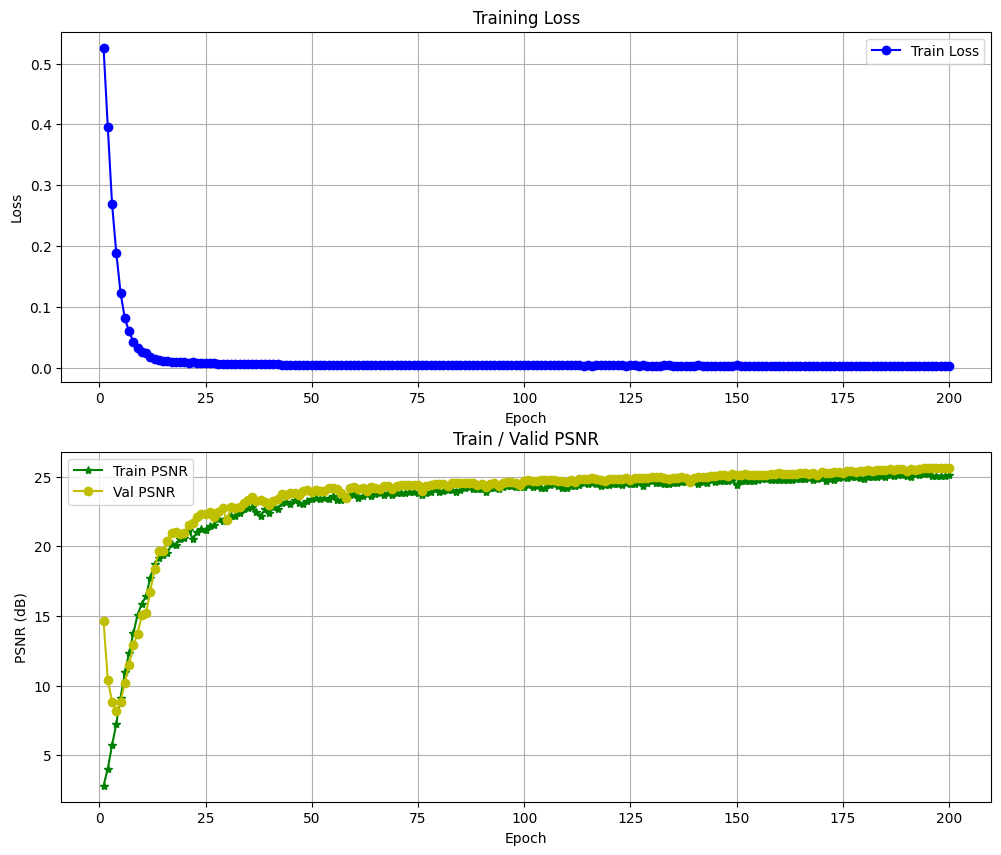

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.plot(range(1, n_epochs+1), train_loss, label='Train Loss', color='blue', marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(212)
plt.plot(range(1, n_epochs+1), train_psnr, label='Train PSNR', color='green', marker='*')
plt.plot(range(1, n_epochs+1), val_psnr_hist, label='Val PSNR', color='y', marker='o')
plt.title("Train / Valid PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend()

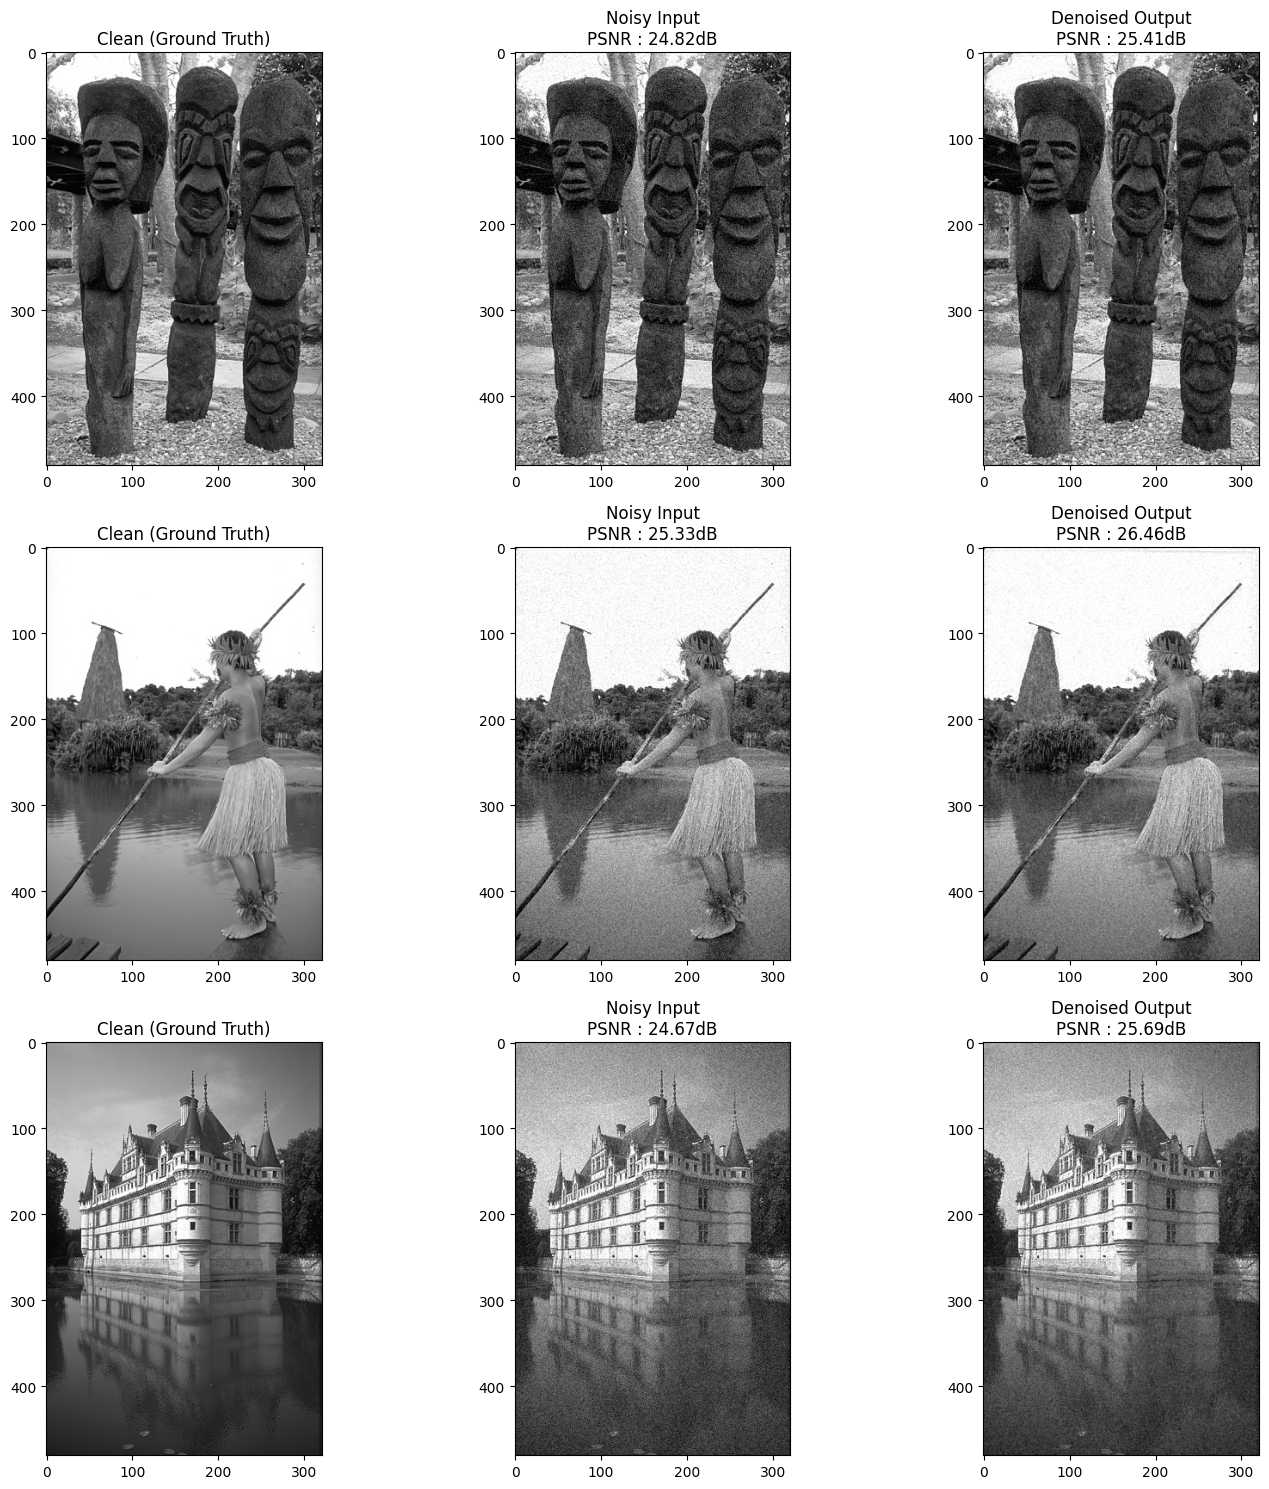

In [22]:
def print_denoised(model, val_loader, num_samples=3):
    model.eval()

    data_iter = iter(val_loader)
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        try:
            inputs, targets = next(data_iter)
        except:
            break
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            denoised_img = inputs - outputs
            denoised_img = torch.clamp(denoised_img, 0.0, 1.0)

        inputs_np = inputs[0].cpu()
        targets_np = targets[0].cpu()
        denoised_np = denoised_img[0].cpu()

        psnr_noisy = calculate_PSNR(inputs_np, targets_np)
        psnr_denoised = calculate_PSNR(denoised_np, targets_np)

        clean_show = targets_np.permute(1, 2, 0).squeeze().numpy()
        noisy_show = inputs_np.permute(1, 2, 0).squeeze().numpy()
        denoised_show = denoised_np.permute(1, 2, 0).squeeze().numpy()

        plt.subplot(num_samples, 3, i*3 +1)
        plt.imshow(clean_show, cmap='gray')
        plt.title(f"Clean (Ground Truth)")
        plt.axis()

        plt.subplot(num_samples, 3, i*3 +2)
        plt.imshow(noisy_show, cmap='gray')
        plt.title(f"Noisy Input\nPSNR : {psnr_noisy:.2f}dB")
        plt.axis()

        plt.subplot(num_samples, 3, i*3 +3)
        plt.imshow(denoised_show, cmap='gray')
        plt.title(f"Denoised Output\nPSNR : {psnr_denoised:.2f}dB")
        plt.axis()

    plt.tight_layout()
    plt.show()

print_denoised(model, val_loader, num_samples=3)